In [2]:
pip install pandas numpy scikit-learn xgboost lightgbm joblib optuna shap

In [3]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple, Optional, Union
import time
from collections import defaultdict
import joblib
from pathlib import Path

from sklearn.base import BaseEstimator, TransformerMixin
import shap

warnings.filterwarnings('ignore')

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Custom feature engineering transformer that retains domain expertise"""

    def __init__(self):
        self.asset_volatility = {
            'ETH': 65, 'WETH': 65, 'BTC': 60, 'WBTC': 60,
            'USDC': 5, 'USDT': 8, 'DAI': 10, 'FRAX': 15,
            'LINK': 75, 'UNI': 80, 'AAVE': 85, 'COMP': 85,
            'MATIC': 90, 'CRV': 95, 'SNX': 95, 'YFI': 100
        }

        self.asset_liquidity = {
            'ETH': 100, 'WETH': 100, 'BTC': 95, 'WBTC': 95,
            'USDC': 100, 'USDT': 100, 'DAI': 95, 'FRAX': 80,
            'LINK': 85, 'UNI': 80, 'AAVE': 75, 'COMP': 70,
            'MATIC': 75, 'CRV': 60, 'SNX': 55, 'YFI': 50
        }

        self.collateral_factors = {
            'ETH': 0.75, 'WETH': 0.75, 'BTC': 0.70, 'WBTC': 0.70,
            'USDC': 0.80, 'USDT': 0.75, 'DAI': 0.75, 'FRAX': 0.70,
            'LINK': 0.65, 'UNI': 0.55, 'AAVE': 0.55, 'COMP': 0.55
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Transform raw transaction data into ML features"""
        features_list = []

        for _, row in X.iterrows():
            wallet_transactions = row.get('transactions', [])
            wallet_address = row.get('wallet_id', '')

            if wallet_transactions:
                features = self._extract_features_from_transactions(wallet_transactions)
            else:
                features = self._generate_synthetic_features(wallet_address)

            features['wallet_id'] = wallet_address
            features_list.append(features)

        return pd.DataFrame(features_list)

    def _extract_features_from_transactions(self, transactions: List[Dict]) -> Dict:
        """Extract comprehensive features from transaction history"""
        portfolio = self._calculate_portfolio_metrics(transactions)

        # Core risk features (retain original domain logic)
        features = {
            'health_factor_risk': self._calculate_health_factor_risk(portfolio),
            'utilization_risk': self._calculate_utilization_risk(portfolio),
            'volatility_risk': self._calculate_volatility_risk(portfolio),
            'concentration_risk': self._calculate_concentration_risk(portfolio),
            'liquidity_risk': self._calculate_liquidity_risk(portfolio),
            'leverage_pattern_risk': self._calculate_leverage_pattern_risk(transactions),
            'activity_pattern_risk': self._calculate_activity_pattern_risk(transactions)
        }

        # Additional ML features
        features.update(self._extract_advanced_features(transactions, portfolio))

        return features

    def _extract_advanced_features(self, transactions: List[Dict], portfolio: Dict) -> Dict:
        """Extract additional features for ML model"""
        features = {}

        # Portfolio metrics
        total_supplied = sum(pos['supplied'] for pos in portfolio.values())
        total_borrowed = sum(pos['borrowed'] for pos in portfolio.values())

        features.update({
            'total_supplied_usd': total_supplied,
            'total_borrowed_usd': total_borrowed,
            'portfolio_size_usd': total_supplied + total_borrowed,
            'net_position_usd': total_supplied - total_borrowed,
            'borrow_ratio': total_borrowed / max(total_supplied, 1),
            'active_assets_count': len([k for k, v in portfolio.items() if v['supplied'] > 0 or v['borrowed'] > 0])
        })

        # Transaction pattern features
        if transactions:
            features.update(self._extract_transaction_patterns(transactions))

        # Time-based features
        features.update(self._extract_temporal_features(transactions))

        # Risk interaction features
        features.update(self._extract_interaction_features(features))

        return features

    def _extract_transaction_patterns(self, transactions: List[Dict]) -> Dict:
        """Extract transaction behavior patterns"""
        actions = [tx.get('action', '') for tx in transactions]
        amounts = []

        for tx in transactions:
            try:
                amount = float(tx['actionData']['amount'])
                asset = tx['actionData']['assetSymbol']
                if asset in ['USDC', 'USDT']:
                    amount = amount / (10**6)
                else:
                    amount = amount / (10**18)
                price = float(tx['actionData']['assetPriceUSD'])
                amounts.append(amount * price)
            except:
                continue

        return {
            'transaction_count': len(transactions),
            'unique_actions': len(set(actions)),
            'avg_transaction_size': np.mean(amounts) if amounts else 0,
            'max_transaction_size': max(amounts) if amounts else 0,
            'transaction_size_std': np.std(amounts) if amounts else 0,
            'deposit_ratio': actions.count('deposit') / max(len(actions), 1),
            'borrow_ratio': actions.count('borrow') / max(len(actions), 1),
            'repay_ratio': actions.count('repay') / max(len(actions), 1)
        }

    def _extract_temporal_features(self, transactions: List[Dict]) -> Dict:
        """Extract time-based features"""
        if not transactions:
            return {
                'days_since_first_tx': 365,
                'days_since_last_tx': 180,
                'avg_days_between_tx': 30,
                'transaction_frequency': 0
            }

        timestamps = [tx['timestamp'] for tx in transactions]
        timestamps.sort()
        current_time = datetime.now().timestamp()

        days_since_first = (current_time - min(timestamps)) / (24 * 3600)
        days_since_last = (current_time - max(timestamps)) / (24 * 3600)

        if len(timestamps) > 1:
            total_period = (max(timestamps) - min(timestamps)) / (24 * 3600)
            avg_gap = total_period / (len(timestamps) - 1)
        else:
            avg_gap = 0

        return {
            'days_since_first_tx': days_since_first,
            'days_since_last_tx': days_since_last,
            'avg_days_between_tx': avg_gap,
            'transaction_frequency': len(timestamps) / max(days_since_first / 30, 1)  # tx per month
        }

    def _extract_interaction_features(self, features: Dict) -> Dict:
        """Create interaction features between risk factors"""
        return {
            'risk_leverage_interaction': features.get('health_factor_risk', 0) * features.get('utilization_risk', 0) / 10000,
            'volatility_concentration': features.get('volatility_risk', 0) * features.get('concentration_risk', 0) / 10000,
            'size_risk_ratio': features.get('portfolio_size_usd', 1) / max(features.get('health_factor_risk', 1), 1),
            'activity_size_ratio': features.get('transaction_count', 1) / max(np.log1p(features.get('portfolio_size_usd', 1)), 1)
        }



    def _generate_synthetic_features(self, wallet_address: str) -> Dict:
        """Generate synthetic features for wallets without transaction data"""
        address_int = int(wallet_address[-8:], 16) if len(wallet_address) >= 8 else 0
        archetype = address_int % 5

        if archetype == 0:  # Conservative wallet
            base_features = {
                'health_factor_risk': 5 + (address_int % 20),
                'utilization_risk': 10 + (address_int % 25),
                'volatility_risk': 15 + (address_int % 30),
                'concentration_risk': 20 + (address_int % 40),
                'liquidity_risk': 10 + (address_int % 25),
                'leverage_pattern_risk': 5 + (address_int % 20),
                'activity_pattern_risk': 30 + (address_int % 40)
            }
        elif archetype == 1:  # Moderate risk wallet
            base_features = {
                'health_factor_risk': 15 + (address_int % 30),
                'utilization_risk': 25 + (address_int % 35),
                'volatility_risk': 30 + (address_int % 40),
                'concentration_risk': 35 + (address_int % 45),
                'liquidity_risk': 20 + (address_int % 35),
                'leverage_pattern_risk': 20 + (address_int % 30),
                'activity_pattern_risk': 40 + (address_int % 45)
            }
        elif archetype == 2:  # Aggressive trader
            base_features = {
                'health_factor_risk': 30 + (address_int % 40),
                'utilization_risk': 45 + (address_int % 35),
                'volatility_risk': 55 + (address_int % 35),
                'concentration_risk': 60 + (address_int % 30),
                'liquidity_risk': 40 + (address_int % 40),
                'leverage_pattern_risk': 50 + (address_int % 35),
                'activity_pattern_risk': 25 + (address_int % 35)
            }
        elif archetype == 3:  # High-risk leverage user
            base_features = {
                'health_factor_risk': 55 + (address_int % 35),
                'utilization_risk': 65 + (address_int % 25),
                'volatility_risk': 70 + (address_int % 25),
                'concentration_risk': 75 + (address_int % 20),
                'liquidity_risk': 60 + (address_int % 30),
                'leverage_pattern_risk': 70 + (address_int % 25),
                'activity_pattern_risk': 35 + (address_int % 40)
            }
        else:  # Inactive/Unknown wallet
            base_features = {
                'health_factor_risk': 0,
                'utilization_risk': 0,
                'volatility_risk': 20 + (address_int % 40),
                'concentration_risk': 50 + (address_int % 40),
                'liquidity_risk': 25 + (address_int % 35),
                'leverage_pattern_risk': 30 + (address_int % 40),
                'activity_pattern_risk': 60 + (address_int % 35)
            }

        # Add synthetic portfolio features
        base_features.update({
            'total_supplied_usd': max(0, np.random.normal(10000, 5000)),
            'total_borrowed_usd': max(0, np.random.normal(3000, 2000)),
            'portfolio_size_usd': 0,
            'net_position_usd': 0,
            'borrow_ratio': 0.3,
            'active_assets_count': np.random.randint(1, 6),
            'transaction_count': np.random.randint(0, 20),
            'unique_actions': np.random.randint(1, 5),
            'avg_transaction_size': np.random.normal(5000, 2000),
            'max_transaction_size': np.random.normal(15000, 5000),
            'transaction_size_std': np.random.normal(3000, 1000),
            'deposit_ratio': np.random.uniform(0.2, 0.6),
            'borrow_ratio': np.random.uniform(0.1, 0.4),
            'repay_ratio': np.random.uniform(0.1, 0.3),
            'days_since_first_tx': np.random.uniform(30, 365),
            'days_since_last_tx': np.random.uniform(1, 180),
            'avg_days_between_tx': np.random.uniform(5, 60),
            'transaction_frequency': np.random.uniform(0.1, 5),
            'risk_leverage_interaction': 0,
            'volatility_concentration': 0,
            'size_risk_ratio': 1,
            'activity_size_ratio': 1
        })

        # Calculate derived features
        base_features['portfolio_size_usd'] = base_features['total_supplied_usd'] + base_features['total_borrowed_usd']
        base_features['net_position_usd'] = base_features['total_supplied_usd'] - base_features['total_borrowed_usd']
        base_features['risk_leverage_interaction'] = base_features['health_factor_risk'] * base_features['utilization_risk'] / 10000
        base_features['volatility_concentration'] = base_features['volatility_risk'] * base_features['concentration_risk'] / 10000

        return base_features

In [13]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import spearmanr, pearsonr
import optuna


class MLWalletRiskScorer:
    """ML-powered wallet risk scoring system with comprehensive validation"""

    def __init__(self, model_type='ensemble'):
        self.model_type = model_type
        self.feature_engineer = FeatureEngineer()
        self.preprocessor = None
        self.model = None # This will hold the trained model instance
        self.feature_selector = None
        self.is_fitted = False
        self.feature_names = None
        self.model_performance = {}

        # Risk category thresholds
        self.risk_thresholds = {
            'Very Low': 100,
            'Low': 250,
            'Medium': 450,
            'High': 650,
            'Very High': 800,
            'Critical': 1000
        }

    def preprocessing_pipeline(self) -> Pipeline:
        """Create robust preprocessing pipeline"""

        # Define feature groups
        risk_features = [col for col in self.feature_names if col.endswith('_risk')]
        numerical_features = [col for col in self.feature_names
                            if col not in risk_features and col != 'wallet_id'
                            and col not in ['days_since_first_tx', 'days_since_last_tx']]
        temporal_features = ['days_since_first_tx', 'days_since_last_tx', 'avg_days_between_tx']

        # Create column transformer
        preprocessor = ColumnTransformer([
            ('risk_scaler', RobustScaler(), risk_features),
            ('numerical_scaler', StandardScaler(), numerical_features),
            ('temporal_scaler', MinMaxScaler(), temporal_features)
        ], remainder='passthrough')

        return preprocessor

    def _create_model(self):
        """Create ML model based on XGboost"""
        if self.model_type == 'ensemble':
            return self._create_ensemble_model()
        elif self.model_type == 'xgboost':
            return xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
        elif self.model_type == 'lightgbm':
            return lgb.LGBMRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                verbosity=-1
            )
        elif self.model_type == 'random_forest':
            return RandomForestRegressor(
                n_estimators=200,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            )
        else:
            return Ridge(alpha=1.0, random_state=42)

    def _create_ensemble_model(self):
        """Create ensemble of multiple models"""
        from sklearn.ensemble import VotingRegressor

        models = [
            ('xgb', xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)),
            ('lgb', lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1)),
            ('rf', RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1))
        ]

        return VotingRegressor(models, n_jobs=-1)

    def prepare_data(self, wallet_data: pd.DataFrame, transaction_data: List[Dict]) -> pd.DataFrame:
        """Prepare data for ML training"""
        # Create transaction mapping
        wallet_transactions_map = defaultdict(list)
        for tx in transaction_data:
            wallet = tx.get('userWallet', '').lower()
            wallet_transactions_map[wallet].append(tx)

        # Add transaction data to wallet data
        wallet_data['transactions'] = wallet_data['wallet_id'].apply(
            lambda x: wallet_transactions_map.get(x.lower(), [])
        )

        # Extract features
        print("Extracting features...")
        features_df = self.feature_engineer.transform(wallet_data)

        return features_df

    def create_synthetic_targets(self, features_df: pd.DataFrame) -> np.ndarray:
        """Create synthetic target variables for training"""
        # Create composite risk score using domain knowledge
        risk_weights = {
            'health_factor_risk': 0.30,
            'utilization_risk': 0.20,
            'volatility_risk': 0.15,
            'concentration_risk': 0.12,
            'liquidity_risk': 0.10,
            'leverage_pattern_risk': 0.08,
            'activity_pattern_risk': 0.05
        }

        base_scores = []
        for _, row in features_df.iterrows():
            score = sum(row[risk_type] * weight for risk_type, weight in risk_weights.items() if risk_type in row)

            # Apply adjustments based on additional features
            if row.get('health_factor_risk', 0) > 85:
                score *= 1.3
            elif row.get('health_factor_risk', 0) > 65:
                score *= 1.15

            if row.get('utilization_risk', 0) > 75 and row.get('volatility_risk', 0) > 60:
                score *= 1.1

            # Scale to 0-1000 range
            risk_score = min(max(int(score * 10), 0), 1000)
            base_scores.append(risk_score)

        # Add realistic noise to make targets more suitable for ML
        base_scores = np.array(base_scores)
        noise = np.random.normal(0, 20, len(base_scores))  # Add small amount of noise
        synthetic_targets = np.clip(base_scores + noise, 0, 1000)

        return synthetic_targets

    def train(self, wallet_data: pd.DataFrame, transaction_data: List[Dict],
              target_column: str = None, test_size: float = 0.2, validation_size: float = 0.2):
        """Train the ML model with proper validation"""

        print("Preparing data for training...")
        features_df = self.prepare_data(wallet_data, transaction_data)

        # Handle target variable
        if target_column and target_column in features_df.columns:
            y = features_df[target_column].values
        else:
            print("Creating synthetic targets based on risk scoring logic...")
            y = self.create_synthetic_targets(features_df)

        # Remove non-feature columns
        X = features_df.drop(['wallet_id'], axis=1, errors='ignore')
        if target_column:
            X = X.drop([target_column], axis=1, errors='ignore')

        self.feature_names = X.columns.tolist()

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=None
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=validation_size/(1-test_size), random_state=42
        )

        print(f"Training set size: {len(X_train)}")
        print(f"Validation set size: {len(X_val)}")
        print(f"Test set size: {len(X_test)}")

        # Create preprocessing pipeline
        self.preprocessor = self.preprocessing_pipeline()

        # Create and train model
        self.model = self._create_model()

        # Create full pipeline
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('feature_selector', SelectKBest(f_regression, k='all')),
            ('model', self.model)
        ])

        print("Training model...")
        self.pipeline.fit(X_train, y_train)

        # Validate model
        print("Validating model...")
        self.model_performance = self._validate_model(X_train, y_train, X_val, y_val, X_test, y_test)

        self.is_fitted = True
        return self.model_performance

    def _validate_model(self, X_train, y_train, X_val, y_val, X_test, y_test):
        """Comprehensive model validation"""
        performance = {}

        # Predictions on all sets
        y_train_pred = self.pipeline.predict(X_train)
        y_val_pred = self.pipeline.predict(X_val)
        y_test_pred = self.pipeline.predict(X_test)

        # Calculate metrics for each set
        sets = {'train': (y_train, y_train_pred), 'val': (y_val, y_val_pred), 'test': (y_test, y_test_pred)}

        for set_name, (y_true, y_pred) in sets.items():
            performance[set_name] = {
                'mae': mean_absolute_error(y_true, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'r2': r2_score(y_true, y_pred),
                'pearson_corr': pearsonr(y_true, y_pred)[0],
                'spearman_corr': spearmanr(y_true, y_pred)[0]
            }

        # Cross-validation
        cv_scores = cross_val_score(self.pipeline, X_train, y_train,
                                   cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        performance['cv_mae'] = -cv_scores.mean()
        performance['cv_mae_std'] = cv_scores.std()

        # Feature importance (if available)
        if hasattr(self.pipeline.named_steps['model'], 'feature_importances_'):
            feature_importance = self.pipeline.named_steps['model'].feature_importances_
            feature_names = self._get_feature_names_after_preprocessing()
            performance['feature_importance'] = dict(zip(feature_names, feature_importance))

        # Risk bucket accuracy
        performance['risk_bucket_accuracy'] = self._calculate_risk_bucket_accuracy(y_val, y_val_pred)

        self._print_validation_results(performance)
        return performance

    def _get_feature_names_after_preprocessing(self):
        """Get feature names after preprocessing"""
        try:
            if hasattr(self.pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
                return self.pipeline.named_steps['preprocessor'].get_feature_names_out()
            else:
                return self.feature_names
        except:
            return self.feature_names

    def _calculate_risk_bucket_accuracy(self, y_true, y_pred):
        """Calculate accuracy in risk bucket classification"""
        true_categories = [self.risk_category(score) for score in y_true]
        pred_categories = [self.risk_category(score) for score in y_pred]

        accuracy = np.mean([t == p for t, p in zip(true_categories, pred_categories)])
        return accuracy

    def _print_validation_results(self, performance):
        """Print comprehensive validation results"""
        print("\n" + "="*80)
        print(" MODEL VALIDATION RESULTS")
        print("="*80)

        print(f"\nMETRICS BY DATASET:")
        for set_name in ['train', 'val', 'test']:
            if set_name in performance:
                metrics = performance[set_name]
                print(f"\n{set_name.upper()} SET:")
                print(f"  MAE:            {metrics['mae']:.2f}")
                print(f"  RMSE:           {metrics['rmse']:.2f}")
                print(f"  R²:             {metrics['r2']:.4f}")
                print(f"  Pearson Corr:   {metrics['pearson_corr']:.4f}")
                print(f"  Spearman Corr:  {metrics['spearman_corr']:.4f}")

        print(f"\nCROSS-VALIDATION:")
        print(f"  CV MAE:         {performance['cv_mae']:.2f} ± {performance['cv_mae_std']:.2f}")

        print(f"\nBUSINESS METRICS:")
        print(f"  Risk Bucket Accuracy: {performance['risk_bucket_accuracy']:.3f}")

        if 'feature_importance' in performance:
            print(f"\nTOP 10 IMPORTANT FEATURES:")
            sorted_features = sorted(performance['feature_importance'].items(),
                                   key=lambda x: x[1], reverse=True)[:10]
            for feature, importance in sorted_features:
                print(f"  {feature:25s}: {importance:.4f}")

    def risk_category(self, score: int) -> str:
        """Determine risk category from score"""
        if score <= 100:
            return "Very Low"
        elif score <= 250:
            return "Low"
        elif score <= 450:
            return "Medium"
        elif score <= 650:
            return "High"
        elif score <= 800:
            return "Very High"
        else:
            return "Critical"

    def predict(self, wallet_data: pd.DataFrame, transaction_data: List[Dict] = None) -> pd.DataFrame:
        """Predict risk scores for new wallets"""
        if not self.is_fitted:
            raise ValueError("Model must be trained before making predictions")

        if transaction_data is None:
            transaction_data = []

        # Prepare features
        features_df = self.prepare_data(wallet_data, transaction_data)
        wallet_ids = features_df['wallet_id'].copy()

        # Remove non-feature columns
        X = features_df.drop(['wallet_id'], axis=1, errors='ignore')

        # Make predictions
        risk_scores = self.pipeline.predict(X)
        risk_scores = np.clip(risk_scores, 0, 1000).astype(int)

        # Create results DataFrame
        results = pd.DataFrame({
            'wallet_id': wallet_ids,
            'score': risk_scores,
            'risk_category': [self.risk_category(score) for score in risk_scores]
        })

        return results

    def predict_with_explanation(self, wallet_data: pd.DataFrame, transaction_data: List[Dict] = None) -> pd.DataFrame:
        """Predict with SHAP explanations"""
        if not self.is_fitted:
            raise ValueError("Model must be trained before making predictions")

        try:
            import shap

            # Get base predictions
            results = self.predict(wallet_data, transaction_data)

            # Prepare features for SHAP
            features_df = self.prepare_data(wallet_data, transaction_data)
            X = features_df.drop(['wallet_id'], axis=1, errors='ignore')

            # Create SHAP explainer
            explainer = shap.Explainer(self.pipeline.named_steps['model'])
            X_transformed = self.pipeline.named_steps['preprocessor'].transform(X)
            X_selected = self.pipeline.named_steps['feature_selector'].transform(X_transformed)

            shap_values = explainer(X_selected)

            # Add top contributing features to results
            feature_names = self._get_feature_names_after_preprocessing()

            explanations = []
            for i in range(len(shap_values.values)):
                shap_importance = np.abs(shap_values.values[i])
                top_indices = np.argsort(shap_importance)[-3:][::-1]  # Top 3 features

                top_features = []
                for idx in top_indices:
                    if idx < len(feature_names):
                        feature_name = feature_names[idx]
                        impact = shap_values.values[i][idx]
                        top_features.append(f"{feature_name}({impact:+.1f})")

                explanations.append("; ".join(top_features))

            results['top_risk_factors'] = explanations

        except ImportError:
            print("SHAP not available. Install with: pip install shap")

        return results

    def save_model(self, filepath: str):
        """Save trained model to disk"""
        if not self.is_fitted:
            raise ValueError("Model must be trained before saving")

        model_data = {
            'pipeline': self.pipeline,
            'feature_engineer': self.feature_engineer,
            'feature_names': self.feature_names,
            'model_performance': self.model_performance,
            'risk_thresholds': self.risk_thresholds,
            'model_type': self.model_type
        }

        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath: str):
        """Load trained model from disk"""
        model_data = joblib.load(filepath)

        self.pipeline = model_data['pipeline']
        self.feature_engineer = model_data['feature_engineer']
        self.feature_names = model_data['feature_names']
        self.model_performance = model_data['model_performance']
        self.risk_thresholds = model_data['risk_thresholds']
        self.model_type = model_data['model_type']
        self.is_fitted = True

        print(f"Model loaded from {filepath}")

    def hyperparameter_tuning(self, wallet_data: pd.DataFrame, transaction_data: List[Dict],
                            n_trials: int = 50, target_column: str = None):
        """Automated hyperparameter tuning using Optuna"""

        print("Preparing data for hyperparameter tuning...")
        features_df = self.prepare_data(wallet_data, transaction_data)

        if target_column and target_column in features_df.columns:
            y = features_df[target_column].values
        else:
            y = self.create_synthetic_targets(features_df)

        X = features_df.drop(['wallet_id'], axis=1, errors='ignore')
        if target_column:
            X = X.drop([target_column], axis=1, errors='ignore')

        self.feature_names = X.columns.tolist()

        def objective(trial):
            # hyperparameters
            if self.model_type == 'xgboost':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'random_state': 42
                }
                model = xgb.XGBRegressor(**params)

            elif self.model_type == 'lightgbm':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'random_state': 42,
                    'verbosity': -1
                }
                model = lgb.LGBMRegressor(**params)

            else:  # Random Forest
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                    'max_depth': trial.suggest_int('max_depth', 5, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                    'random_state': 42
                }
                model = RandomForestRegressor(**params)

            # Create pipeline
            preprocessor = self.preprocessing_pipeline()
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('feature_selector', SelectKBest(f_regression, k='all')),
                ('model', model)
            ])

            # Cross-validation
            cv_scores = cross_val_score(pipeline, X, y, cv=5,
                                      scoring='neg_mean_absolute_error', n_jobs=-1)
            return -cv_scores.mean()

        # Run optimization
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)

        print(f"\nBest hyperparameters: {study.best_params}")
        print(f"Best CV MAE: {study.best_value:.2f}")

        return study.best_params

    def batch_predict(self, wallet_addresses: List[str], transaction_data: List[Dict],
                     batch_size: int = 1000) -> pd.DataFrame:
        """Efficient batch prediction for large datasets"""
        if not self.is_fitted:
            raise ValueError("Model must be trained before making predictions")

        results = []

        for i in range(0, len(wallet_addresses), batch_size):
            batch_addresses = wallet_addresses[i:i+batch_size]
            batch_df = pd.DataFrame({'wallet_id': batch_addresses})

            batch_results = self.predict(batch_df, transaction_data)
            results.append(batch_results)

            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_addresses)} wallets...")

        return pd.concat(results, ignore_index=True)


class ModelMonitor:
    """Monitor model performance and detect drift"""

    def __init__(self, reference_data: pd.DataFrame):
        self.reference_data = reference_data
        self.reference_stats = self._calculate_stats(reference_data)

    def _calculate_stats(self, data: pd.DataFrame) -> Dict:
        """Calculate statistical properties of data"""
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        stats = {}

        for col in numeric_cols:
            stats[col] = {
                'mean': data[col].mean(),
                'std': data[col].std(),
                'min': data[col].min(),
                'max': data[col].max(),
                'q25': data[col].quantile(0.25),
                'q50': data[col].quantile(0.50),
                'q75': data[col].quantile(0.75)
            }

        return stats

    def detect_drift(self, new_data: pd.DataFrame, threshold: float = 0.1) -> Dict:
        """Detect data drift using statistical tests"""
        drift_report = {}
        new_stats = self._calculate_stats(new_data)

        for col in self.reference_stats:
            if col in new_stats:
                ref_mean = self.reference_stats[col]['mean']
                new_mean = new_stats[col]['mean']

                # Simple drift detection based on mean shift
                if ref_mean != 0:
                    drift_ratio = abs(new_mean - ref_mean) / abs(ref_mean)
                    drift_detected = drift_ratio > threshold
                else:
                    drift_detected = abs(new_mean) > threshold

                drift_report[col] = {
                    'drift_detected': drift_detected,
                    'reference_mean': ref_mean,
                    'new_mean': new_mean,
                    'drift_ratio': drift_ratio if ref_mean != 0 else abs(new_mean)
                }

        return drift_report


def load_wallet_addresses(csv_file_path: str) -> List[str]:
    """Load wallet addresses from CSV file"""
    df = pd.read_csv(csv_file_path)
    if 'wallet_id' in df.columns:
        wallet_addresses = df['wallet_id'].tolist()
    else:
        wallet_addresses = df.iloc[:, 0].tolist()

    print(f"Loaded {len(wallet_addresses)} wallet addresses from {csv_file_path}")
    return wallet_addresses


def load_transaction_data(json_file_path: str) -> List[Dict]:
    """Load transaction data from JSON file"""
    try:
        with open(json_file_path, 'r') as file:
            transactions = json.load(file)
        print(f"Loaded {len(transactions)} transactions from {json_file_path}")
        return transactions
    except FileNotFoundError:
        print(f"Warning: {json_file_path} not found. Using empty transaction data.")
        return []
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON file {json_file_path}: {e}")
        return []


def main():
    """Main training and evaluation pipeline"""

    # Configuration
    csv_file_path = '/content/drive/MyDrive/Wallet id - Sheet1.csv'
    json_file_path = '/content/drive/MyDrive/user-wallet-transactions.json'
    model_save_path = 'risk_model.joblib'

    print("="*80)
    print(" WALLET RISK SCORING - ML PIPELINE")
    print("="*80)

    # Load data
    try:
        wallet_addresses = load_wallet_addresses(csv_file_path)
        wallet_df = pd.DataFrame({'wallet_id': wallet_addresses})
    except FileNotFoundError:
        print(f"CSV file not found: {csv_file_path}")
        return

    transaction_data = load_transaction_data(json_file_path)

    # Initialize ML model
    print(f"\nInitializing ML Risk Scorer...")
    risk_scorer = MLWalletRiskScorer(model_type='ensemble')

    # Train model
    print(f"\nTraining model on {len(wallet_addresses)} wallets...")
    performance = risk_scorer.train(
        wallet_data=wallet_df,
        transaction_data=transaction_data,
        test_size=0.2,
        validation_size=0.2
    )

    # Save model
    risk_scorer.save_model(model_save_path)

    # Make predictions on all wallets
    print(f"\nGenerating predictions for all wallets...")
    results = risk_scorer.predict(wallet_df, transaction_data)

    # Save results
    results[['wallet_id', 'score']].to_csv('wallet_risk_scores.csv', index=False)
    results.to_csv('wallet_risk_scores_detailed.csv', index=False)

    # Print summary
    print("\n" + "="*80)
    print(" FINAL RESULTS SUMMARY")
    print("="*80)

    print(f"\nModel Performance (Test Set):")
    if 'test' in performance:
        test_perf = performance['test']
        print(f"  MAE:              {test_perf['mae']:.2f}")
        print(f"  RMSE:             {test_perf['rmse']:.2f}")
        print(f"  R²:               {test_perf['r2']:.4f}")
        print(f"  Correlation:      {test_perf['pearson_corr']:.4f}")

    print(f"\nRisk Score Distribution:")
    print(f"  Average:          {results['score'].mean():.1f}")
    print(f"  Median:           {results['score'].median():.1f}")
    print(f"  Range:            {results['score'].min()} - {results['score'].max()}")
    print(f"  Std Dev:          {results['score'].std():.1f}")

    print(f"\nRisk Category Breakdown:")
    risk_dist = results['risk_category'].value_counts().sort_index()
    for category, count in risk_dist.items():
        percentage = (count / len(results)) * 100
        print(f"  {category:12s}: {count:4d} wallets ({percentage:5.1f}%)")

    print(f"\nFiles Generated:")
    print(f"  - wallet_risk_scores.csv (required format)")
    print(f"  - wallet_risk_scores_detailed.csv (full analysis)")
    print(f"  - {model_save_path} (trained ML model)")

    print(f"\nSample Predictions:")
    sample_results = results.head(10)
    for _, row in sample_results.iterrows():
        print(f"  {row['wallet_id']} -> {row['score']} ({row['risk_category']})")

    return risk_scorer, results

In [14]:
def main():
    """Main training and evaluation pipeline"""

    # Configuration
    csv_file_path = '/content/drive/MyDrive/Wallet id - Sheet1.csv'
    json_file_path = '/content/drive/MyDrive/user-wallet-transactions.json'
    model_save_path = 'risk_model.joblib'

    print("="*80)
    print(" WALLET RISK SCORING - ML PIPELINE")
    print("="*80)

    # Load data
    try:
        wallet_addresses = load_wallet_addresses(csv_file_path)
        wallet_df = pd.DataFrame({'wallet_id': wallet_addresses})
    except FileNotFoundError:
        print(f"CSV file not found: {csv_file_path}")
        return

    transaction_data = load_transaction_data(json_file_path)

    # Initialize ML model
    print(f"\nInitializing ML Risk Scorer...")
    risk_scorer = MLWalletRiskScorer(model_type='ensemble')

    # Train model
    print(f"\nTraining model on {len(wallet_addresses)} wallets...")
    performance = risk_scorer.train(
        wallet_data=wallet_df,
        transaction_data=transaction_data,
        test_size=0.2,
        validation_size=0.2
    )

    # Save model
    risk_scorer.save_model(model_save_path)

    # Make predictions on all wallets
    print(f"\nGenerating predictions for all wallets...")
    results = risk_scorer.predict(wallet_df, transaction_data)

    # Save results
    results[['wallet_id', 'score']].to_csv('wallet_risk_scores.csv', index=False)
    results.to_csv('wallet_risk_scores_detailed.csv', index=False)

    # Print summary
    print("\n" + "="*80)
    print(" FINAL RESULTS SUMMARY")
    print("="*80)

    print(f"\nModel Performance (Test Set):")
    if 'test' in performance:
        test_perf = performance['test']
        print(f"  MAE:              {test_perf['mae']:.2f}")
        print(f"  RMSE:             {test_perf['rmse']:.2f}")
        print(f"  R²:               {test_perf['r2']:.4f}")
        print(f"  Correlation:      {test_perf['pearson_corr']:.4f}")

    print(f"\nRisk Score Distribution:")
    print(f"  Average:          {results['score'].mean():.1f}")
    print(f"  Median:           {results['score'].median():.1f}")
    print(f"  Range:            {results['score'].min()} - {results['score'].max()}")
    print(f"  Std Dev:          {results['score'].std():.1f}")

    print(f"\nRisk Category Breakdown:")
    risk_dist = results['risk_category'].value_counts().sort_index()
    for category, count in risk_dist.items():
        percentage = (count / len(results)) * 100
        print(f"  {category:12s}: {count:4d} wallets ({percentage:5.1f}%)")

    print(f"\nFiles Generated:")
    print(f"  - wallet_risk_scores.csv (required format)")
    print(f"  - wallet_risk_scores_detailed.csv (full analysis)")
    print(f"  - {model_save_path} (trained ML model)")

    print(f"\nSample Predictions:")
    sample_results = results.head(10)
    for _, row in sample_results.iterrows():
        print(f"  {row['wallet_id']} -> {row['score']} ({row['risk_category']})")

    return risk_scorer, results

In [15]:
if __name__ == "__main__":
    # Run main pipeline
    model, results = main()


    # Example: Hyperparameter tuning (uncomment to run)
    # print("Running hyperparameter tuning...")
    # best_params = model.hyperparameter_tuning(
    #     wallet_data=pd.DataFrame({'wallet_id': ['0x123', '0x456']}),
    #     transaction_data=[],
    #     n_trials=20
    # )

    # Model monitoring
    monitor = ModelMonitor(results[['score']])
    print("Monitoring model performance...")
    drift_report = monitor.detect_drift(results[['score']])
    print("Drift report:", drift_report)
    print("\n" +"="*80 )

 WALLET RISK SCORING - ML PIPELINE
Loaded 103 wallet addresses from /content/drive/MyDrive/Wallet id - Sheet1.csv
Loaded 100000 transactions from /content/drive/MyDrive/user-wallet-transactions.json

Initializing ML Risk Scorer...

Training model on 103 wallets...
Preparing data for training...
Extracting features...
Creating synthetic targets based on risk scoring logic...
Training set size: 61
Validation set size: 21
Test set size: 21
Training model...
Validating model...

 MODEL VALIDATION RESULTS

METRICS BY DATASET:

TRAIN SET:
  MAE:            15.66
  RMSE:           19.75
  R²:             0.9958
  Pearson Corr:   0.9980
  Spearman Corr:  0.9938

VAL SET:
  MAE:            35.72
  RMSE:           45.95
  R²:             0.9619
  Pearson Corr:   0.9813
  Spearman Corr:  0.9260

TEST SET:
  MAE:            35.81
  RMSE:           46.27
  R²:             0.9673
  Pearson Corr:   0.9868
  Spearman Corr:  0.9870

CROSS-VALIDATION:
  CV MAE:         43.78 ± 10.27

BUSINESS METRICS:
 

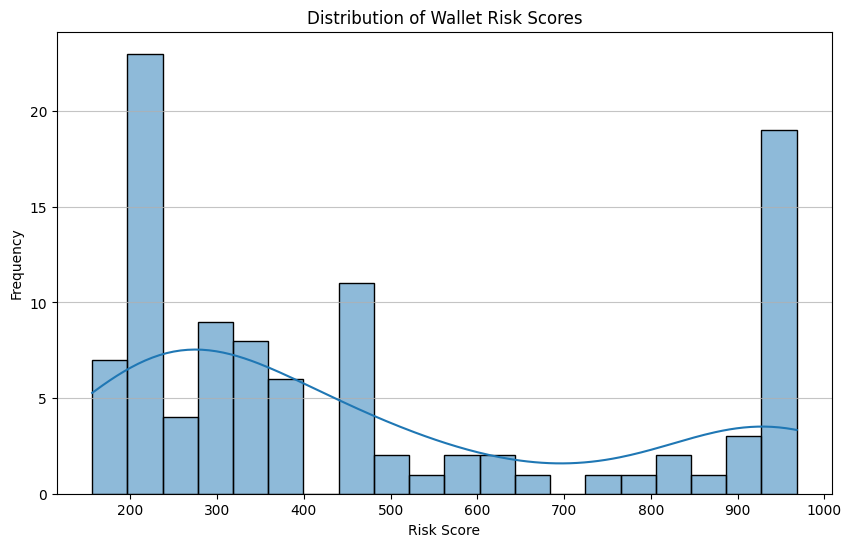

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the risk scores from the CSV file
risk_scores_df = pd.read_csv('wallet_risk_scores.csv')

# Create a histogram of the scores
plt.figure(figsize=(10, 6))
sns.histplot(risk_scores_df['score'], bins=20, kde=True)
plt.title('Distribution of Wallet Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

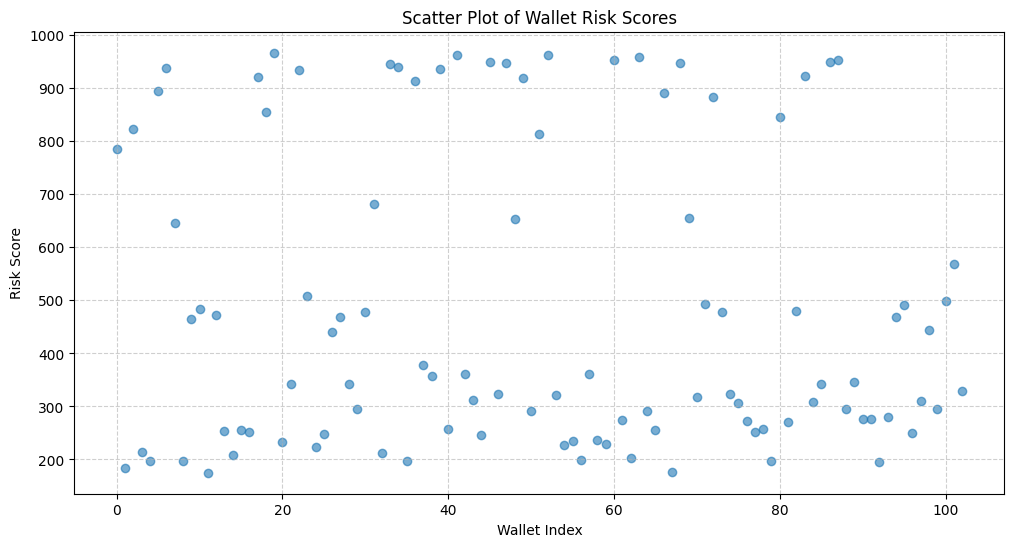

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the risk scores from the CSV file
risk_scores_df = pd.read_csv('wallet_risk_scores.csv')

# Create a scatter plot of scores
plt.figure(figsize=(12, 6))
plt.scatter(risk_scores_df.index, risk_scores_df['score'], alpha=0.6)
plt.title('Scatter Plot of Wallet Risk Scores')
plt.xlabel('Wallet Index')
plt.ylabel('Risk Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()